This is the third and final notebook we will be using for this LDA model. The first one was to find the best number of topics, the second one was to find the 
best numbers for our hyperparameters. Now this one we will build the final model and visualize it. The changes we will make here are preprocessing the data.
Data preparation is important when building a data model, so we will find the best way to preprocess the data and how we should make the n-grams (what the 
threshold and mincounts should be).

In [3]:
!pip install nltk==3.5
# Make sure to have nltk and stopwords downloaded
import nltk; nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!pip install gensim==3.8.3
!pip install spacy==2.3.2
!pip install pyLDAvis==2.1.2

# Import needed packages

import re
import numpy
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format="%(asctime)s: %(levelname)s : %(message)s", level=logging.ERROR)

import warnings 
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 9.9 MB 6.3 MB/s 
     |████████████████████████████████| 284 kB 59.9 MB/s 
     |████████████████████████████████| 3.7 MB 39.9 MB/s 
     |████████████████████████████████| 2.1 MB 40.5 MB/s 
     |████████████████████████████████| 293 kB 52.8 MB/s 
     |████████████████████████████████| 1.6 MB 19.2 MB/s 
     |████████████████████████████████| 162 kB 44.0 MB/s 
     |████████████████████████████████| 272 kB 36.4 MB/s 
     |████████████████████████████████| 829 kB 30.4 MB/s 
     |████████████████████████████████| 99 kB 20.6 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=88d236da8f1a74ef2f6c4d1e0a758cab76c3793d9cfcede94584f34ce1ffacca
  Stored in directory: /home/jovyan/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=0d608877753c45f6e4e932b3ba2b10d160f674eb550cd7b3d4abe97691bf578

In [5]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Get data
df = pd.read_csv('../data/text_analysis_data.csv')
df.head()

,Date received,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,Tags,Company response to consumer,Timely response?,Consumer disputed?,month,year
0,2020-05-19,Private student loan,Dealing with your lender or servicer,Received bad information about your loan,When I was applying for my loan my XXXX accoun...,"Figure Technologies, Inc",NJ,None,Closed with explanation,Yes,NaN,5,2020
1,2020-02-06,Federal student loan servicing,Incorrect information on your report,Account status incorrect,I'm on a deferred payment plan t never ; late,"Nelnet, Inc.",TX,None,Closed with explanation,Yes,NaN,2,2020
2,2020-02-08,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,I have attempted multiple times to contact FED...,AES/PHEAA,KY,None,Closed with non-monetary relief,Yes,NaN,2,2020
3,2020-01-21,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I was divorced in 2004 and I agreed to take th...,AES/PHEAA,OK,None,Closed with explanation,Yes,NaN,1,2020
4,2019-12-04,Federal student loan servicing,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,This particular account situation that is late...,AES/PHEAA,FL,None,Closed with explanation,Yes,NaN,12,2019


Now that we've imported the necessary packages we will prepare the data to build and feed into the model. This 
pre-processing function was changed and ran a few times to see what we should get rid of that made sense to yield 
the highest coherence score.

In [7]:
!pip install textblob==0.15.3
!python -m textblob.download_corpora

# A function to preprocess all rows in a dataframe
def preprocess_data(data):
    # Change all text to lowercase
    data = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove puctuation
    data = data.str.replace("[^\w\s]","")
    
    # Remove stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words("english")
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Lemmatize words
    from textblob import Word
    data = data.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    # Remove words with length below 3
    data = data.apply(lambda x: " ".join(x for x in x.split() if len(x) >= 3))
    
    # Remove any words like "xx" words and numbers
    data = data.apply(lambda x: " ".join(x for x in x.split() if "xx" not in x))
    data = data.apply(lambda x: " ".join(x for x in x.split() if not x.isnumeric()))

    # This round we decided not to remove common words
    freq = pd.Series(" ".join(data).split()).value_counts()[:10]
    freq = list(freq.index)
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in freq))

    # Remove super large words
    data = data.apply(lambda x: " ".join(x for x in x.split() if len(x) < 15))
    
    # Remove rare words
    freq = pd.Series(lambda x: " ".join(data).split()).value_counts()[-10:]
    freq = list(freq.index)
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    
    # Return transformed data
    return data

# Return the data as a list
data = preprocess_data(df["Consumer complaint narrative"])

     |████████████████████████████████| 636 kB 17.0 MB/s 
[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [8]:
# Tokenize the data
data = [sub.split() for sub in data] 
print(data[:3])

[['applying', 'correctly', 'communicate', 'issue', 'offer', 'rate', 'deduction', 'autopay', 'showing', 'told', 'application', 'anyway', 'opened', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'since', 'opened', 'called', 'call', 'center', 'least', 'trying', 'receive', 'autopay', 'discount', 'first', 'told', 'going', 'applied', 'still', 'seen', 'additionally', 'last', 'called', 'week', 'ago', 'asked', 'speak', 'manager', 'told', 'take', 'day', 'get', 'back', 'still', 'yet', 'hear', 'back', 'business', 'day', 'later', 'told', 'receiving', 'autopay', 'discount', 'receiving', 'opened', 'company', 'lying', 'rate', 'going', 'receive', 'dont', 'autopay', 'initiate', 'autopays', 'far', 'additional', 'issue', 'told', 'rate', 'going', 'based', 'libor', 'rate', 'published', 'wsj', 'none', 'rate', 'received', 'thus', 'far', 'match', 'rate', 'dont', 'really', 'know', 'tried', 'contacting', 'many', 'people', 'phone', 'seem', 'helpful', 'talking', 'nothing', 'seems', 'get', 'done', 'hang']

Now that we've cleaned and tokenized the data we need to create bigrams and trigrams. Bigrams are two words frequently seen paired together, trigrams are the same but with three words. We will use Gensim's Phrases model to build the bigrams and trigrams.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['applying', 'correctly', 'communicate', 'issue', 'offer', 'rate', 'deduction', 'autopay', 'showing', 'told', 'application', 'anyway', 'opened', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'since', 'opened', 'called', 'call', 'center', 'least', 'trying', 'receive', 'autopay', 'discount', 'first', 'told', 'going', 'applied', 'still', 'seen', 'additionally', 'last', 'called', 'week', 'ago', 'asked', 'speak', 'manager', 'told', 'take', 'day', 'get', 'back', 'still', 'yet', 'hear', 'back', 'business', 'day', 'later', 'told', 'receiving', 'autopay', 'discount', 'receiving', 'opened', 'company', 'lying', 'rate', 'going', 'receive', 'dont', 'autopay', 'initiate', 'autopays', 'far', 'additional', 'issue', 'told', 'rate', 'going', 'based', 'libor', 'rate', 'published', 'wsj', 'none', 'rate', 'received', 'thus_far', 'match', 'rate', 'dont', 'really', 'know', 'tried', 'contacting', 'many', 'people', 'phone', 'seem', 'helpful', 'talking', 'nothing', 'seems', 'get', 'done', 'hang']


In [10]:
# Here we are defining functions for bigrams, trigrams, and lemmatizing the data

def make_bigrams(data):
    return [bigram_mod[doc] for doc in data]

def make_trigrams(data):
    return [trigram_mod[bigram_mod[doc]] for doc in data]

def lemmatization(data, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    complaints_out = []
    for complaint in data:
        doc = nlp(" ".join(complaint))
        complaints_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return complaints_out

In [11]:
!python3 -m spacy download en
# Now we call the functions we build above
data_words_bigrams = make_bigrams(data)
nlp = spacy.load("en", disable=["parser", "ner"])
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

     |████████████████████████████████| 12.0 MB 39.6 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=840c43c5892230530dbfe89b87aeacaab2e04787427d160b7ac8e79a5b97f13f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ngv5x3kd/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/venv/lib/python3.7/site-packages/en_core_web_sm -->
/opt/venv/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
[['apply', 'correctly', 'communicate', 'issue', 'offer', 'rate', 'deduction', 'autopay', 'show', 'tell', 'application', 'anyway', 'open', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'open', 'call', 'center', 'least', 'try', 'receive', 'discount', 'first', 'tell', 'go', 'apply', 'still', 'see', 'additionally', 'last', 'ca

At this point we've created some bi_grams and tri_grams. Now we need to create a dictionary and corpus that's needed for topic modeling.

In [12]:
# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
complaints = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(complaint) for complaint in complaints]

print("Corpus format: (word_id, work_frequency)")
print(corpus[:1])
print()
print("Readable version of term-frequency:")
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

Corpus format: (word_id, work_frequency)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 6), (45, 1), (46, 6), (47, 1), (48, 2), (49, 1), (50, 2), (51, 1), (52, 1), (53, 5), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1)]]

Readable version of term-frequency:
[[('add', 1), ('additional', 1), ('additionally', 1), ('anyway', 1), ('application', 1), ('apply', 2), ('ask', 1), ('autopay', 5), ('back', 1), ('base', 1), ('business', 1), ('call', 2), ('center', 1), ('communicate', 1), ('company', 1), ('contact', 1), ('correctly', 1), ('could', 1), ('day', 2), ('deduction', 1), ('discount', 3), ('do', 1), ('far', 1), ('first', 1), ('get', 2), ('go', 2), ('goi

Now that we've prepared the data we are going to create and use a new function to test the other hypertunning parameters for an lda model, hopefully find one that's more accurate.

In [13]:
# Create the optimal model
optimal_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=8,
                                              random_state=100,
                                              chunksize=100,
                                              passes=10,
                                              alpha="symmetric",
                                              eta=0.909999999,
                                              per_word_topics=True)

In [14]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=optimal_lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence score:", coherence_lda)


Coherence score: 0.48042261941619635


This is the best coherence score we've been able to obtain so far. We've gotten the best hyper-parameters and 
number of topics for this model. Now we can start to visualize the results of the LDA model and take a look at
the different topics it created. 

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.208370  0.047078       1        1  30.958509
5      0.171464 -0.041986       2        1  29.989832
6      0.121261 -0.023782       3        1  11.731980
3      0.087108 -0.074297       4        1  10.679008
0      0.030149 -0.004855       5        1  10.223989
4     -0.113206  0.250991       6        1   3.809379
2     -0.227864 -0.144886       7        1   2.396960
1     -0.277282 -0.008263       8        1   0.210339, topic_info=             Term          Freq         Total Category  logprob  loglift
73         credit  13678.000000  13678.000000  Default  30.0000  30.0000
93            pay  38835.000000  38835.000000  Default  29.0000  29.0000
147        report   8301.000000   8301.000000  Default  28.0000  28.0000
130        school   7683.000000   7683.000000  Default  27.0000  27.0000
11           call  29216.000000  29216.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
17315       topay      0.719794      7.853397   Topic8  -8.6815   3.7745
1370       global      1.013467     18.382824   Topic8  -8.3393   3.2662
6730    agressive      0.733683      8.615646   Topic8  -8.6624   3.7009
5689   forgivness      0.769684     18.636475   Topic8  -8.6145   2.9773
3391      qualife      0.741530     13.632236   Topic8  -8.6518   3.2527

[548 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6822      1  0.040404  60day
6822      2  0.040404  60day
6822      3  0.040404  60day
6822      4  0.040404  60day
6822      5  0.040404  60day
...     ...       ...    ...
3225      3  0.005915  young
3225      4  0.005915  young
3225      5  0.002957  young
3225      6  0.002957  young
3225      7  0.005915  young

[3267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 4, 1, 5, 3, 2])

In [16]:
# Lets take a look at the keywords for each topic
model_topics = optimal_lda_model.show_topics(formatted=False)
pprint(optimal_lda_model.print_topics(num_words=10))

[(0,
  '0.018*"debt" + 0.013*"information" + 0.012*"provide" + 0.012*"collection" + '
  '0.011*"request" + 0.010*"letter" + 0.009*"file" + 0.009*"send" + '
  '0.009*"receive" + 0.008*"state"'),
 (1,
  '0.011*"ameritech" + 0.006*"cosignor" + 0.002*"osla" + '
  '0.000*"borrowerspouse" + 0.000*"foregiveness" + 0.000*"reoayment" + '
  '0.000*"repeatly" + 0.000*"couldnot" + 0.000*"wavier" + 0.000*"sticky"'),
 (2,
  '0.102*"school" + 0.035*"attend" + 0.024*"class" + 0.021*"degree" + '
  '0.020*"college" + 0.015*"university" + 0.011*"aid" + 0.011*"enrol" + '
  '0.010*"close" + 0.010*"program"'),
 (3,
  '0.034*"plan" + 0.031*"repayment" + 0.025*"income" + 0.025*"program" + '
  '0.024*"forgiveness" + 0.021*"application" + 0.017*"service" + '
  '0.017*"forbearance" + 0.016*"qualify" + 0.015*"make"'),
 (4,
  '0.130*"credit" + 0.108*"report" + 0.041*"late" + 0.019*"score" + '
  '0.019*"remove" + 0.016*"reporting" + 0.013*"show" + 0.013*"day" + '
  '0.011*"bureau" + 0.011*"dispute"'),
 (5,
  '0.036

In [17]:
# Now we create a dataframe that shows each document, the topic its assigned to,
# and the percentage of how confident the model is the document belongs to that topic.

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7365,"call, receive, tell, make, send, say, email, i...","[applying, correctly, communicate, issue, offe..."
1,1,4.0,0.6202,"credit, report, late, score, remove, reporting...","[deferred, plan, never, late]"
2,2,7.0,0.5488,"call, receive, tell, make, send, say, email, i...","[attempted, multiple, contact, fedloan, via, o..."
3,3,5.0,0.6343,"pay, make, tell, help, take, call, could, get,...","[divorced, agreed, take, school, divorce, cons..."
4,4,4.0,0.8943,"credit, report, late, score, remove, reporting...","[particular, situation, lately, filing, credit..."
5,5,4.0,0.9687,"credit, report, late, score, remove, reporting...","[particular, situation, lately, filing, credit..."
6,6,6.0,0.4513,"pay, amount, rate, balance, make, principal, m...","[complaint, educational, management, corp, tri..."
7,7,5.0,0.6451,"pay, make, tell, help, take, call, could, get,...","[income, based, repayment, stating, longer, ca..."
8,8,6.0,0.4714,"pay, amount, rate, balance, make, principal, m...","[issue, way, back, maybe, tired, figure, take,..."
9,9,6.0,0.5698,"pay, amount, rate, balance, make, principal, m...","[amount, evenly, dispersed, principle, balance..."


In [18]:
# Showing the top 5 documents (ordered percentage confidence desc) for each topic, now we export this 
# dataframe to a .csv document to review it and make sense of what each topic is talking about

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

# pd.DataFrame.to_csv(sent_topics_sorteddf_mallet, "most_representative_sentence_per_topic.csv")

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9828,"debt, information, provide, collection, request, letter, file, send, receive, state","[ecmc, behalf, servicer, furnish, proof, debt, owe, debt, requested, original, document, origina..."
1,0.0,0.9801,"debt, information, provide, collection, request, letter, file, send, receive, state","[wrote, letter, inquiring, transaction, titled, sale, disclosed, information, associated, transa..."
2,0.0,0.9717,"debt, information, provide, collection, request, letter, file, send, receive, state","[request, debt, validation, demand, see, copy, verifiable, validated, proof, original, consumer,..."
3,0.0,0.9687,"debt, information, provide, collection, request, letter, file, send, receive, state","[allied, interstae, received, debt, however, debt, formally, disputed, prior, sent, collection, ..."
4,0.0,0.9662,"debt, information, provide, collection, request, letter, file, send, receive, state","[appeal, dispute, reissued, plausible, inquiry, probable, identity, theft, consumer, financial, ..."
5,1.0,0.3426,"ameritech, cosignor, osla, borrowerspouse, foregiveness, reoayment, repeatly, couldnot, wavier, ...","[university, company, friendly, pay, monthly, butmy, continue, updue, rate, anysolutions, help, ..."
6,2.0,0.8250,"school, attend, class, degree, college, university, aid, enrol, close, program","[attended, school, attended, closed]"
7,2.0,0.8247,"school, attend, class, degree, college, university, aid, enrol, close, program","[mislead, fraudulent, school, take, high]"
8,2.0,0.8039,"school, attend, class, degree, college, university, aid, enrol, close, program","[school, closed, beefore, finish, held, responsible, school, lied]"
9,2.0,0.7992,"school, attend, class, degree, college, university, aid, enrol, close, program","[started, art, insititute, finished, art, institue, fallen, victim, predatory, lending, mislead,..."


     |████████████████████████████████| 366 kB 12.3 MB/s 


IndexError: list index out of range

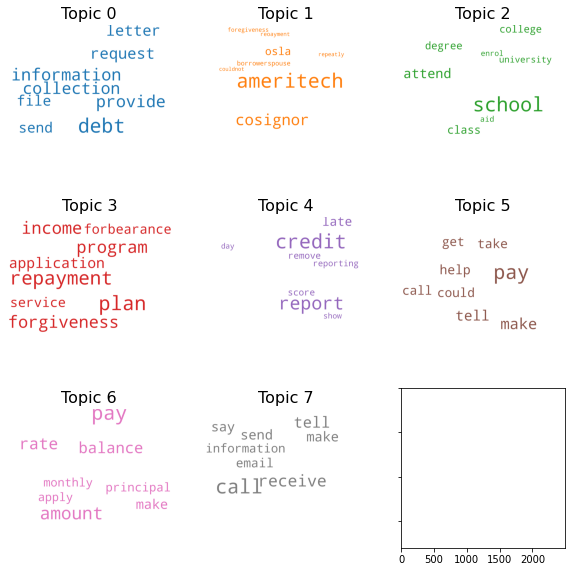

In [19]:
# A cool wordcloud visualization for each topic (pretty basic but I like it)

!pip install wordcloud

from matplotlib import pyplot as pyplot
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                    background_color="white",
                    width=2500,
                    height=1800,
                    max_words=8,
                    colormap="tab10",
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

topics = optimal_lda_model.show_topics(formatted=False)

fig, axis = plt.subplots(3, 3
, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axis.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic " + str(i), fontdict=dict(size=16))
    plt.gca().axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


These next two cells create and show a bar graph showing how many documents are included in each topic.

In [20]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [21]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, ax = plt.subplots( figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax.xaxis.set_major_formatter(tick_formatter)
ax.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

Text(0, 0.5, 'Number of Documents')

In [22]:
pd.DataFrame.to_csv(sent_topics_sorteddf_mallet, "most_representative_sentence_per_topic.csv")